<a href="https://colab.research.google.com/github/dewaalaw/dsprojects/blob/main/search-term-analysis/src/coffee_search_trend_part_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Development Environment

In [25]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation

from pandas.tseries.offsets import MonthEnd
from itertools import product
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

## Read Training Data

In [16]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [5]:
csv_path = '/gdrive/MyDrive/SearchTermAnalysis/data/monthly_coffee_search_nam_2014-2018.csv'
df = pd.read_csv(csv_path)
df.head()

,Month,Coffee
0,2014-08,36
1,2014-09,0
2,2014-10,30
3,2014-11,25
4,2014-12,20


# Data Exploration

In [6]:
# Examine Column Data Types
df.dtypes

Month     object
Coffee     int64
dtype: object

In [9]:
# Convert Month object to date-time, adding last day of month as datestamp
df['Month'] = pd.to_datetime(df['Month']) + MonthEnd(1)
df.dtypes

Month     datetime64[ns]
Coffee             int64
dtype: object

In [8]:
# Examine new labels
df.head()

,Month,Coffee
0,2014-08-31,36
1,2014-09-30,0
2,2014-10-31,30
3,2014-11-30,25
4,2014-12-31,20


In [10]:
df.tail()

,Month,Coffee
102,2023-03-31,48
103,2023-04-30,47
104,2023-05-31,49
105,2023-06-30,61
106,2023-07-31,100


In [11]:
df.shape

(107, 2)

## Visualise Coffee Search Trend Over Time 

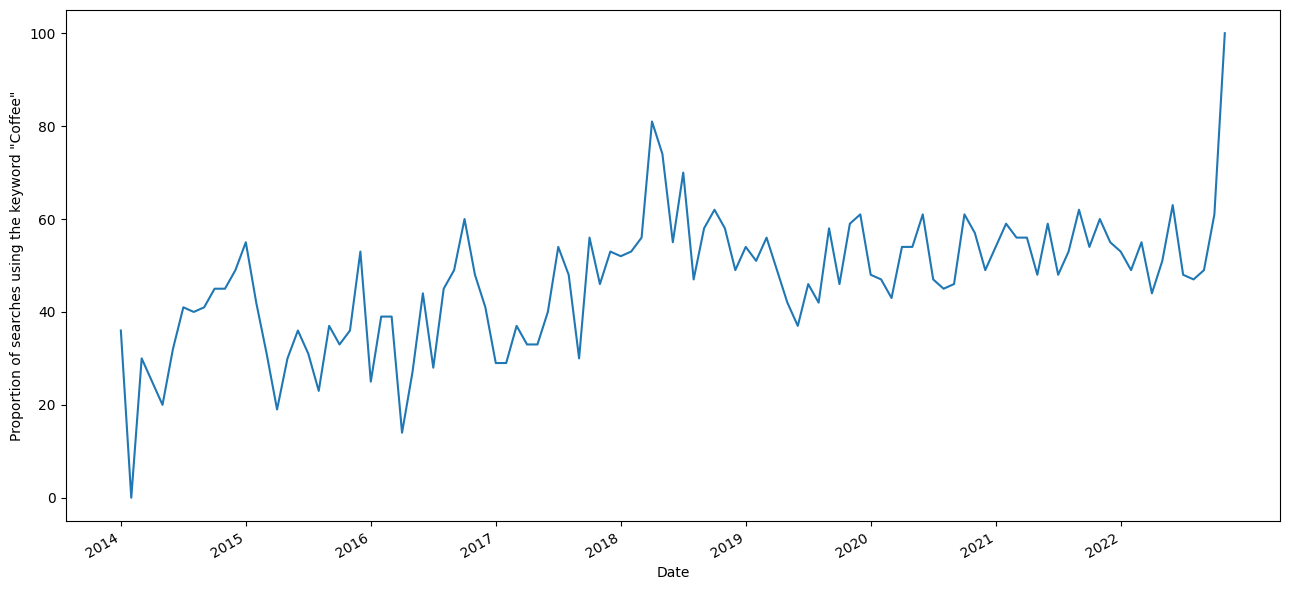

In [12]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df['Coffee'])
ax.set_xlabel('Date')
ax.set_ylabel('Proportion of searches using the keyword "Coffee"')

plt.xticks(np.arange(0, 107, 12), np.arange(2014, 2023, 1))

fig.autofmt_xdate()
plt.tight_layout()

In [13]:
df.columns = ['ds', 'y']

In [14]:
train = df[:-12]
# Keep the last 12 months for testing
test = df[-12:]  

# Hyperparameter Tuning & Cross Validation

In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
    }

all_params = [dict(zip(param_grid.keys(), v)) for v in 
              product(*param_grid.values())]

cutoffs = pd.date_range(start='2019-01-31', end='2021-01-31', freq='12M')

mses = []

for param in all_params:
  m = Prophet(**param)
  m.add_country_holidays(country_name='NAM')
  m.fit(train)

  df_cv = cross_validation(model=m, horizon='365 days', cutoffs=cutoffs)
  df_p = performance_metrics(df_cv, rolling_window=1)
  mses.append(df_p['mse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['mse'] = mses

## Best Parameters from H-tuning

In [22]:
best_params = all_params[np.argmin(mses)]
(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}

In [23]:
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)

In [29]:
test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat',
                                                       'yhat_lower', 'yhat_upper']]

test['baseline'] = train['y'][-12:].values 

prophet_mae = mean_absolute_error(test['y'], test['y'])
baseline_mae = mean_absolute_error(test['y'], test['baseline'])

## Plot

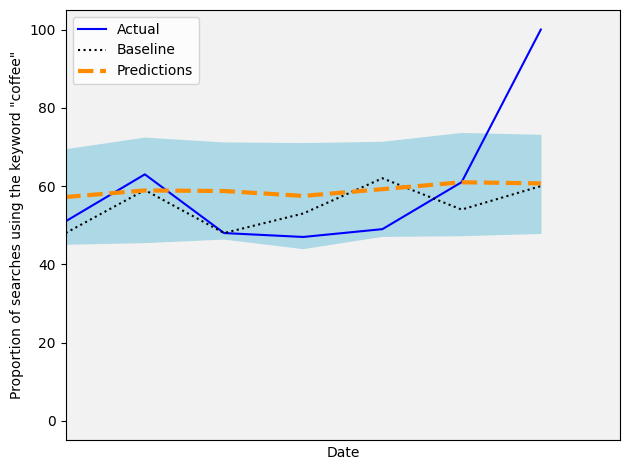

In [28]:
fig, ax = plt.subplots()

ax.plot(train['y'])
ax.plot(test['y'], 'b-', label='Actual')
ax.plot(test['baseline'], 'k:', label='Baseline')
ax.plot(test['yhat'], color='darkorange', ls='--', lw=3, label='Predictions')

ax.set_xlabel('Date')
ax.set_ylabel('Proportion of searches using the keyword "coffee"')

ax.axvspan(90, 107, color='#808080', alpha=0.1)

ax.legend(loc='best')

plt.xticks(np.arange(0, 107, 12), np.arange(2014, 2023, 1))
plt.fill_between(x=test.index, y1=test['yhat_lower'],
                 y2=test['yhat_upper'], color='lightblue')
plt.xlim(100, 107)

fig.autofmt_xdate()
plt.tight_layout()